In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Set seeds
np.random.seed(10)
tf.random.set_seed(10)

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda, Dropout, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPooling2D

from tensorflow.keras import optimizers, models, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import mse, binary_crossentropy

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import seaborn as sns
import re
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import matplotlib.ticker as mtick

/home/rmlans/anaconda3/envs/tf2_env/lib/python3.6/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


### Load Data

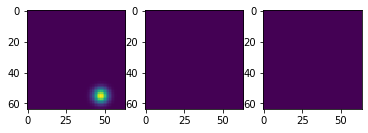

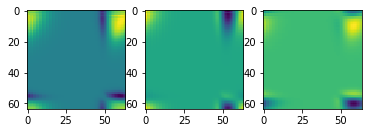

In [2]:
swe_data = np.transpose(np.load('./Science_Data/train.npy'))
swe_data_v = np.transpose(np.load('./Science_Data/validation.npy'))

swe_train_data = np.zeros(shape=(400,64,64,3)) # Channels last
swe_valid_data = np.zeros(shape=(400,64,64,3)) # Channels last

for i in range(np.shape(swe_data)[0]):
    temp_1 = swe_data[i,0:64*64].reshape(64,64)
    temp_2 = swe_data[i,64*64:2*64*64].reshape(64,64)
    temp_3 = swe_data[i,2*64*64:3*64*64].reshape(64,64)
    swe_train_data[i,:,:,0] = np.transpose(temp_1[:,:])
    swe_train_data[i,:,:,1] = np.transpose(temp_2[:,:])
    swe_train_data[i,:,:,2] = np.transpose(temp_3[:,:])
    
for i in range(np.shape(swe_data)[0]):
    temp_1 = swe_data_v[i,0:64*64].reshape(64,64)
    temp_2 = swe_data_v[i,64*64:2*64*64].reshape(64,64)
    temp_3 = swe_data_v[i,2*64*64:3*64*64].reshape(64,64)
    swe_valid_data[i,:,:,0] = np.transpose(temp_1[:,:])
    swe_valid_data[i,:,:,1] = np.transpose(temp_2[:,:])
    swe_valid_data[i,:,:,2] = np.transpose(temp_3[:,:])
    

# Just to keep things simple
swe_train_data = swe_train_data[0:200,:,:,:]
swe_valid_data = swe_valid_data[0:200,:,:,:]

for j in range(3):
    swe_train_data[:,:,:,j] = (swe_train_data[:,:,:,j] - np.min(swe_train_data[:,:,:,0]))/(np.max(swe_train_data[:,:,:,0])-np.min(swe_train_data[:,:,:,0]))
    swe_valid_data[:,:,:,j] = (swe_valid_data[:,:,:,j] - np.min(swe_valid_data[:,:,:,0]))/(np.max(swe_valid_data[:,:,:,0])-np.min(swe_valid_data[:,:,:,0]))

# Visualize one time instance
time = 0
fig, ax = plt.subplots(nrows=1,ncols=3)

ax[0].imshow(swe_train_data[time,:,:,0])
ax[1].imshow(swe_train_data[time,:,:,1])
ax[2].imshow(swe_train_data[time,:,:,2])
plt.show()


# Visualize one time instance
time = 20
fig, ax = plt.subplots(nrows=1,ncols=3)

ax[0].imshow(swe_valid_data[time,:,:,0])
ax[1].imshow(swe_valid_data[time,:,:,1])
ax[2].imshow(swe_valid_data[time,:,:,2])
plt.show()

### ML Presets and Custom Functions

In [3]:
mode = 'train'
lrate = 0.0001

latent_dim = 2*2*2
epsilon_mean = 0.1
epsilon_std = 1e-4

def coeff_determination(y_pred, y_true): #Order of function inputs is important here        
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# reparameterization trick for VAE
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
     Arguments
        args (tensor): mean and log of variance of Q(z|X)
     Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim), mean=epsilon_mean, stddev=epsilon_std)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [4]:
# Define recursive model architecture
weights_filepath = './saved_models/SWE_VAE_Weights.h5'
# Encoder    
encoder_inputs = Input(shape=(64,64,3),name='Field')
# Encode   
x = Conv2D(30,kernel_size=(3,3),activation='relu',padding='same')(encoder_inputs)
enc_l2 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(25,kernel_size=(3,3),activation='relu',padding='same')(enc_l2)
enc_l3 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(20,kernel_size=(3,3),activation='relu',padding='same')(enc_l3)
enc_l4 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(15,kernel_size=(3,3),activation='relu',padding='same')(enc_l4)
enc_l5 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(2,kernel_size=(3,3),activation=None,padding='same')(enc_l5)
encoded = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation=None)(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs=encoder_inputs, outputs=z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Field (InputLayer)              [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 30)   840         Field[0][0]                      
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 30)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 25)   6775        max_pooling2d[0][0]              
____________________________________________________________________________________________

In [5]:
# Build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(16, activation='relu')(latent_inputs)
x = Dense(32, activation='relu')(x)
x = Dense(2*2*2, activation=None)(x)
x = Reshape((2, 2, 2))(x)
   
x = Conv2D(2,kernel_size=(3,3),activation=None,padding='same')(x)
dec_l1 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(15,kernel_size=(3,3),activation='relu',padding='same')(dec_l1)
dec_l2 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(20,kernel_size=(3,3),activation='relu',padding='same')(dec_l2)
dec_l3 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(25,kernel_size=(3,3),activation='relu',padding='same')(dec_l3)
dec_l4 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(30,kernel_size=(3,3),activation='relu',padding='same')(dec_l4)
dec_l5 = UpSampling2D(size=(2, 2))(x)

decoded = Conv2D(3,kernel_size=(3,3),activation=None,padding='same')(dec_l5)
decoder = Model(inputs=latent_inputs,outputs=decoded)

decoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 8)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 264       
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 2)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 2)           38        
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 4, 4, 2)           0     

In [6]:
# instantiate VAE model
outputs = decoder(encoder(encoder_inputs))
model = Model(inputs=encoder_inputs,outputs=outputs, name='VAE')

In [7]:
# Calculate custom loss in separate function
reconstruction_loss = binary_crossentropy(K.flatten(encoder_inputs), K.flatten(outputs))
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
vae_loss = K.mean(reconstruction_loss - 0.5*kl_loss)
model.add_loss(vae_loss)

In [8]:
num_epochs = 5000
batch_size = 4

# design network
my_adam = optimizers.Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

checkpoint = ModelCheckpoint(weights_filepath, monitor='loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
earlystopping = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks_list = [checkpoint]

model.compile(optimizer=my_adam,metrics=[coeff_determination])
model.summary()

if mode == 'train':
    # train the autoencoder
    model.fit(x=swe_train_data,y=swe_train_data,epochs=num_epochs, batch_size=batch_size, validation_split=0.1, callbacks=callbacks_list)
    model.save_weights(weights_filepath)

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Field (InputLayer)              [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 8)            16978       Field[0][0]                      
__________________________________________________________________________________________________
model (Model)                   (None, 64, 64, 3)    16113       encoder[1][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 30)   840         Field[0][0]                      
________________________________________________________________________________________________

45/45 [==============================] - ETA: 0s - loss: 0.3453 - coeff_determination: -4628.6855
Epoch 00001: loss improved from inf to 0.34530, saving model to ./saved_models/SWE_VAE_Weights.h5
45/45 [==============================] - 2s 37ms/step - loss: 0.3453 - coeff_determination: -4628.6855 - val_loss: 0.3025 - val_coeff_determination: -255.0550
Epoch 2/5000
44/45 [============================>.] - ETA: 0s - loss: 0.2399 - coeff_determination: -120.4265
Epoch 00002: loss improved from 0.34530 to 0.23932, saving model to ./saved_models/SWE_VAE_Weights.h5
45/45 [==============================] - 1s 27ms/step - loss: 0.2393 - coeff_determination: -118.8304 - val_loss: 0.2845 - val_coeff_determination: -40.3156
Epoch 3/5000
45/45 [==============================] - ETA: 0s - loss: 0.1876 - coeff_determination: -22.7019
Epoch 00003: loss improved from 0.23932 to 0.18760, saving model to ./saved_models/SWE_VAE_Weights.h5
45/45 [==============================] - 1s 26ms/step - loss: 0.1

45/45 [==============================] - ETA: 0s - loss: 0.0704 - coeff_determination: 0.2517
Epoch 00024: loss improved from 0.07393 to 0.07043, saving model to ./saved_models/SWE_VAE_Weights.h5
45/45 [==============================] - 2s 33ms/step - loss: 0.0704 - coeff_determination: 0.2517 - val_loss: 0.1287 - val_coeff_determination: 0.4112
Epoch 25/5000
45/45 [==============================] - ETA: 0s - loss: 0.0697 - coeff_determination: 0.2636
Epoch 00025: loss improved from 0.07043 to 0.06969, saving model to ./saved_models/SWE_VAE_Weights.h5
45/45 [==============================] - 1s 33ms/step - loss: 0.0697 - coeff_determination: 0.2636 - val_loss: 0.1112 - val_coeff_determination: 0.3558
Epoch 26/5000
45/45 [==============================] - ETA: 0s - loss: 0.0670 - coeff_determination: 0.2441
Epoch 00026: loss improved from 0.06969 to 0.06696, saving model to ./saved_models/SWE_VAE_Weights.h5
45/45 [==============================] - 2s 34ms/step - loss: 0.0670 - coeff_det

45/45 [==============================] - ETA: 0s - loss: 0.0295 - coeff_determination: 0.3480
Epoch 00047: loss improved from 0.03191 to 0.02950, saving model to ./saved_models/SWE_VAE_Weights.h5
45/45 [==============================] - 2s 34ms/step - loss: 0.0295 - coeff_determination: 0.3480 - val_loss: 0.0924 - val_coeff_determination: 0.4358
Epoch 48/5000
45/45 [==============================] - ETA: 0s - loss: 0.0279 - coeff_determination: 0.3477
Epoch 00048: loss improved from 0.02950 to 0.02787, saving model to ./saved_models/SWE_VAE_Weights.h5
45/45 [==============================] - 2s 34ms/step - loss: 0.0279 - coeff_determination: 0.3477 - val_loss: 0.0806 - val_coeff_determination: 0.4103
Epoch 49/5000
45/45 [==============================] - ETA: 0s - loss: 0.0260 - coeff_determination: 0.3432
Epoch 00049: loss improved from 0.02787 to 0.02604, saving model to ./saved_models/SWE_VAE_Weights.h5
45/45 [==============================] - 2s 34ms/step - loss: 0.0260 - coeff_det

Epoch 72/5000
45/45 [==============================] - ETA: 0s - loss: 0.0089 - coeff_determination: 0.4017
Epoch 00072: loss improved from 0.00990 to 0.00893, saving model to ./saved_models/SWE_VAE_Weights.h5
45/45 [==============================] - 2s 33ms/step - loss: 0.0089 - coeff_determination: 0.4017 - val_loss: 0.0887 - val_coeff_determination: 0.4776
Epoch 73/5000
45/45 [==============================] - ETA: 0s - loss: 0.0103 - coeff_determination: 0.4097
Epoch 00073: loss did not improve from 0.00893
45/45 [==============================] - 1s 33ms/step - loss: 0.0103 - coeff_determination: 0.4097 - val_loss: 0.0802 - val_coeff_determination: 0.4604
Epoch 74/5000
45/45 [==============================] - ETA: 0s - loss: 0.0068 - coeff_determination: 0.4090
Epoch 00074: loss improved from 0.00893 to 0.00679, saving model to ./saved_models/SWE_VAE_Weights.h5
45/45 [==============================] - 2s 34ms/step - loss: 0.0068 - coeff_determination: 0.4090 - val_loss: 0.0734 - v

Epoch 97/5000
45/45 [==============================] - ETA: 0s - loss: -8.1468e-04 - coeff_determination: 0.4492
Epoch 00097: loss did not improve from -0.00172
45/45 [==============================] - 1s 33ms/step - loss: -8.1468e-04 - coeff_determination: 0.4492 - val_loss: 0.0598 - val_coeff_determination: 0.5561
Epoch 98/5000
45/45 [==============================] - ETA: 0s - loss: -0.0014 - coeff_determination: 0.4647
Epoch 00098: loss did not improve from -0.00172
45/45 [==============================] - 1s 33ms/step - loss: -0.0014 - coeff_determination: 0.4647 - val_loss: 0.0652 - val_coeff_determination: 0.5788
Epoch 99/5000
45/45 [==============================] - ETA: 0s - loss: -0.0013 - coeff_determination: 0.4583
Epoch 00099: loss did not improve from -0.00172
45/45 [==============================] - 1s 33ms/step - loss: -0.0013 - coeff_determination: 0.4583 - val_loss: 0.0692 - val_coeff_determination: 0.5972
Epoch 100/5000
45/45 [==============================] - ETA: 0

Epoch 122/5000
45/45 [==============================] - ETA: 0s - loss: -0.0082 - coeff_determination: 0.4977
Epoch 00122: loss did not improve from -0.01010
45/45 [==============================] - 2s 39ms/step - loss: -0.0082 - coeff_determination: 0.4977 - val_loss: 0.0560 - val_coeff_determination: 0.6066
Epoch 123/5000
45/45 [==============================] - ETA: 0s - loss: -0.0102 - coeff_determination: 0.5000
Epoch 00123: loss improved from -0.01010 to -0.01018, saving model to ./saved_models/SWE_VAE_Weights.h5
45/45 [==============================] - 2s 35ms/step - loss: -0.0102 - coeff_determination: 0.5000 - val_loss: 0.0547 - val_coeff_determination: 0.6256
Epoch 124/5000
45/45 [==============================] - ETA: 0s - loss: -0.0109 - coeff_determination: 0.4937
Epoch 00124: loss improved from -0.01018 to -0.01087, saving model to ./saved_models/SWE_VAE_Weights.h5
45/45 [==============================] - 2s 37ms/step - loss: -0.0109 - coeff_determination: 0.4937 - val_lo

Epoch 147/5000
45/45 [==============================] - ETA: 0s - loss: -0.0145 - coeff_determination: 0.5369
Epoch 00147: loss did not improve from -0.01562
45/45 [==============================] - 1s 33ms/step - loss: -0.0145 - coeff_determination: 0.5369 - val_loss: 0.0568 - val_coeff_determination: 0.6574
Epoch 148/5000
45/45 [==============================] - ETA: 0s - loss: -0.0120 - coeff_determination: 0.5224
Epoch 00148: loss did not improve from -0.01562
45/45 [==============================] - 1s 33ms/step - loss: -0.0120 - coeff_determination: 0.5224 - val_loss: 0.0650 - val_coeff_determination: 0.6673
Epoch 149/5000
45/45 [==============================] - ETA: 0s - loss: -0.0130 - coeff_determination: 0.5411
Epoch 00149: loss did not improve from -0.01562
45/45 [==============================] - 2s 34ms/step - loss: -0.0130 - coeff_determination: 0.5411 - val_loss: 0.0503 - val_coeff_determination: 0.6635
Epoch 150/5000
45/45 [==============================] - ETA: 0s - l

Epoch 173/5000
45/45 [==============================] - ETA: 0s - loss: -0.0104 - coeff_determination: 0.5521
Epoch 00173: loss did not improve from -0.01793
45/45 [==============================] - 1s 33ms/step - loss: -0.0104 - coeff_determination: 0.5521 - val_loss: 0.0674 - val_coeff_determination: 0.6776
Epoch 174/5000
45/45 [==============================] - ETA: 0s - loss: -0.0135 - coeff_determination: 0.5521
Epoch 00174: loss did not improve from -0.01793
45/45 [==============================] - 1s 33ms/step - loss: -0.0135 - coeff_determination: 0.5521 - val_loss: 0.0596 - val_coeff_determination: 0.6415
Epoch 175/5000
45/45 [==============================] - ETA: 0s - loss: -0.0052 - coeff_determination: 0.5394
Epoch 00175: loss did not improve from -0.01793
45/45 [==============================] - 2s 34ms/step - loss: -0.0052 - coeff_determination: 0.5394 - val_loss: 0.0677 - val_coeff_determination: 0.6209
Epoch 176/5000
45/45 [==============================] - ETA: 0s - l

Epoch 198/5000
44/45 [============================>.] - ETA: 0s - loss: 0.0070 - coeff_determination: 0.5582
Epoch 00198: loss did not improve from -0.02181
45/45 [==============================] - 2s 42ms/step - loss: 0.0069 - coeff_determination: 0.5582 - val_loss: 0.0841 - val_coeff_determination: 0.6917
Epoch 199/5000
45/45 [==============================] - ETA: 0s - loss: 0.0019 - coeff_determination: 0.5732     
Epoch 00199: loss did not improve from -0.02181
45/45 [==============================] - 2s 44ms/step - loss: 0.0019 - coeff_determination: 0.5732 - val_loss: 0.1327 - val_coeff_determination: 0.6165
Epoch 200/5000
44/45 [============================>.] - ETA: 0s - loss: 0.0038 - coeff_determination: 0.5718
Epoch 00200: loss did not improve from -0.02181
45/45 [==============================] - 2s 44ms/step - loss: 0.0037 - coeff_determination: 0.5691 - val_loss: 0.1042 - val_coeff_determination: 0.6352
Epoch 201/5000
44/45 [============================>.] - ETA: 0s - lo

45/45 [==============================] - ETA: 0s - loss: -0.0120 - coeff_determination: 0.6078
Epoch 00224: loss did not improve from -0.02181
45/45 [==============================] - 2s 45ms/step - loss: -0.0120 - coeff_determination: 0.6078 - val_loss: 0.0611 - val_coeff_determination: 0.7141
Epoch 225/5000
45/45 [==============================] - ETA: 0s - loss: -0.0161 - coeff_determination: 0.5935
Epoch 00225: loss did not improve from -0.02181
45/45 [==============================] - 1s 33ms/step - loss: -0.0161 - coeff_determination: 0.5935 - val_loss: 0.0527 - val_coeff_determination: 0.6851
Epoch 226/5000
45/45 [==============================] - ETA: 0s - loss: -0.0206 - coeff_determination: 0.5946
Epoch 00226: loss did not improve from -0.02181
45/45 [==============================] - 2s 34ms/step - loss: -0.0206 - coeff_determination: 0.5946 - val_loss: 0.0680 - val_coeff_determination: 0.5667
Epoch 227/5000
45/45 [==============================] - ETA: 0s - loss: -0.0156 - 

Epoch 250/5000
45/45 [==============================] - ETA: 0s - loss: -0.0221 - coeff_determination: 0.6158
Epoch 00250: loss did not improve from -0.02461
45/45 [==============================] - 1s 33ms/step - loss: -0.0221 - coeff_determination: 0.6158 - val_loss: 0.0589 - val_coeff_determination: 0.7026
Epoch 251/5000
45/45 [==============================] - ETA: 0s - loss: -0.0195 - coeff_determination: 0.6079
Epoch 00251: loss did not improve from -0.02461
45/45 [==============================] - 2s 33ms/step - loss: -0.0195 - coeff_determination: 0.6079 - val_loss: 0.0582 - val_coeff_determination: 0.6260
Epoch 252/5000
45/45 [==============================] - ETA: 0s - loss: -0.0135 - coeff_determination: 0.6063
Epoch 00252: loss did not improve from -0.02461
45/45 [==============================] - 1s 32ms/step - loss: -0.0135 - coeff_determination: 0.6063 - val_loss: 0.0517 - val_coeff_determination: 0.6559
Epoch 253/5000
45/45 [==============================] - ETA: 0s - l

Epoch 276/5000
45/45 [==============================] - ETA: 0s - loss: -0.0265 - coeff_determination: 0.6211
Epoch 00276: loss improved from -0.02617 to -0.02650, saving model to ./saved_models/SWE_VAE_Weights.h5
45/45 [==============================] - 1s 33ms/step - loss: -0.0265 - coeff_determination: 0.6211 - val_loss: 0.0569 - val_coeff_determination: 0.6713
Epoch 277/5000
45/45 [==============================] - ETA: 0s - loss: -0.0240 - coeff_determination: 0.6205
Epoch 00277: loss did not improve from -0.02650
45/45 [==============================] - 1s 32ms/step - loss: -0.0240 - coeff_determination: 0.6205 - val_loss: 0.0549 - val_coeff_determination: 0.6754
Epoch 278/5000
45/45 [==============================] - ETA: 0s - loss: -0.0244 - coeff_determination: 0.6213
Epoch 00278: loss did not improve from -0.02650
45/45 [==============================] - 1s 32ms/step - loss: -0.0244 - coeff_determination: 0.6213 - val_loss: 0.0518 - val_coeff_determination: 0.6700
Epoch 279/5

Epoch 302/5000
45/45 [==============================] - ETA: 0s - loss: -0.0277 - coeff_determination: 0.6313
Epoch 00302: loss improved from -0.02714 to -0.02766, saving model to ./saved_models/SWE_VAE_Weights.h5
45/45 [==============================] - 2s 37ms/step - loss: -0.0277 - coeff_determination: 0.6313 - val_loss: 0.0561 - val_coeff_determination: 0.6800
Epoch 303/5000
45/45 [==============================] - ETA: 0s - loss: -0.0278 - coeff_determination: 0.6331
Epoch 00303: loss improved from -0.02766 to -0.02785, saving model to ./saved_models/SWE_VAE_Weights.h5
45/45 [==============================] - 2s 34ms/step - loss: -0.0278 - coeff_determination: 0.6331 - val_loss: 0.0533 - val_coeff_determination: 0.6807
Epoch 304/5000
45/45 [==============================] - ETA: 0s - loss: -0.0284 - coeff_determination: 0.6320
Epoch 00304: loss improved from -0.02785 to -0.02843, saving model to ./saved_models/SWE_VAE_Weights.h5
45/45 [==============================] - 1s 33ms/ste

Epoch 328/5000
45/45 [==============================] - ETA: 0s - loss: -0.0247 - coeff_determination: 0.6386
Epoch 00328: loss did not improve from -0.02921
45/45 [==============================] - 1s 32ms/step - loss: -0.0247 - coeff_determination: 0.6386 - val_loss: 0.0594 - val_coeff_determination: 0.6459
Epoch 329/5000
45/45 [==============================] - ETA: 0s - loss: -0.0243 - coeff_determination: 0.6302
Epoch 00329: loss did not improve from -0.02921
45/45 [==============================] - 1s 32ms/step - loss: -0.0243 - coeff_determination: 0.6302 - val_loss: 0.0593 - val_coeff_determination: 0.6750
Epoch 330/5000
44/45 [============================>.] - ETA: 0s - loss: -0.0277 - coeff_determination: 0.6364
Epoch 00330: loss did not improve from -0.02921
45/45 [==============================] - 2s 34ms/step - loss: -0.0280 - coeff_determination: 0.6325 - val_loss: 0.0642 - val_coeff_determination: 0.6444
Epoch 331/5000
45/45 [==============================] - ETA: 0s - l

45/45 [==============================] - ETA: 0s - loss: -0.0300 - coeff_determination: 0.6454
Epoch 00354: loss improved from -0.02928 to -0.03001, saving model to ./saved_models/SWE_VAE_Weights.h5
45/45 [==============================] - 1s 33ms/step - loss: -0.0300 - coeff_determination: 0.6454 - val_loss: 0.0661 - val_coeff_determination: 0.6404
Epoch 355/5000
45/45 [==============================] - ETA: 0s - loss: -0.0262 - coeff_determination: 0.6410
Epoch 00355: loss did not improve from -0.03001
45/45 [==============================] - 1s 32ms/step - loss: -0.0262 - coeff_determination: 0.6410 - val_loss: 0.0644 - val_coeff_determination: 0.6077
Epoch 356/5000
45/45 [==============================] - ETA: 0s - loss: -0.0289 - coeff_determination: 0.6500
Epoch 00356: loss did not improve from -0.03001
45/45 [==============================] - 2s 37ms/step - loss: -0.0289 - coeff_determination: 0.6500 - val_loss: 0.0555 - val_coeff_determination: 0.6457
Epoch 357/5000
45/45 [====

Epoch 380/5000
45/45 [==============================] - ETA: 0s - loss: -0.0294 - coeff_determination: 0.6607
Epoch 00380: loss did not improve from -0.03120
45/45 [==============================] - 2s 34ms/step - loss: -0.0294 - coeff_determination: 0.6607 - val_loss: 0.0563 - val_coeff_determination: 0.6631
Epoch 381/5000
45/45 [==============================] - ETA: 0s - loss: -0.0300 - coeff_determination: 0.6611
Epoch 00381: loss did not improve from -0.03120
45/45 [==============================] - 1s 32ms/step - loss: -0.0300 - coeff_determination: 0.6611 - val_loss: 0.0802 - val_coeff_determination: 0.6138
Epoch 382/5000
45/45 [==============================] - ETA: 0s - loss: -0.0313 - coeff_determination: 0.6625
Epoch 00382: loss improved from -0.03120 to -0.03132, saving model to ./saved_models/SWE_VAE_Weights.h5
45/45 [==============================] - 2s 34ms/step - loss: -0.0313 - coeff_determination: 0.6625 - val_loss: 0.0766 - val_coeff_determination: 0.6128
Epoch 383/5

Epoch 406/5000
45/45 [==============================] - ETA: 0s - loss: -0.0319 - coeff_determination: 0.6659
Epoch 00406: loss did not improve from -0.03217
45/45 [==============================] - 2s 35ms/step - loss: -0.0319 - coeff_determination: 0.6659 - val_loss: 0.0762 - val_coeff_determination: 0.6226
Epoch 407/5000
45/45 [==============================] - ETA: 0s - loss: -0.0293 - coeff_determination: 0.6730
Epoch 00407: loss did not improve from -0.03217
45/45 [==============================] - 1s 33ms/step - loss: -0.0293 - coeff_determination: 0.6730 - val_loss: 0.0774 - val_coeff_determination: 0.6051
Epoch 408/5000
45/45 [==============================] - ETA: 0s - loss: -0.0279 - coeff_determination: 0.6633
Epoch 00408: loss did not improve from -0.03217
45/45 [==============================] - 1s 33ms/step - loss: -0.0279 - coeff_determination: 0.6633 - val_loss: 0.0768 - val_coeff_determination: 0.5989
Epoch 409/5000
45/45 [==============================] - ETA: 0s - l

45/45 [==============================] - ETA: 0s - loss: 0.0233 - coeff_determination: 0.6124
Epoch 00431: loss did not improve from -0.03317
45/45 [==============================] - 2s 34ms/step - loss: 0.0233 - coeff_determination: 0.6124 - val_loss: 0.0840 - val_coeff_determination: 0.6740
Epoch 432/5000
45/45 [==============================] - ETA: 0s - loss: 0.0052 - coeff_determination: 0.6240
Epoch 00432: loss did not improve from -0.03317
45/45 [==============================] - 2s 37ms/step - loss: 0.0052 - coeff_determination: 0.6240 - val_loss: 0.0828 - val_coeff_determination: 0.6755
Epoch 433/5000
45/45 [==============================] - ETA: 0s - loss: -0.0043 - coeff_determination: 0.6530
Epoch 00433: loss did not improve from -0.03317
45/45 [==============================] - 2s 36ms/step - loss: -0.0043 - coeff_determination: 0.6530 - val_loss: 0.0743 - val_coeff_determination: 0.6927
Epoch 434/5000
45/45 [==============================] - ETA: 0s - loss: -0.0111 - coef

Epoch 458/5000
45/45 [==============================] - ETA: 0s - loss: -0.0329 - coeff_determination: 0.6822
Epoch 00458: loss did not improve from -0.03317
45/45 [==============================] - 2s 36ms/step - loss: -0.0329 - coeff_determination: 0.6822 - val_loss: 0.0919 - val_coeff_determination: 0.5954
Epoch 459/5000
45/45 [==============================] - ETA: 0s - loss: -0.0328 - coeff_determination: 0.6814
Epoch 00459: loss did not improve from -0.03317
45/45 [==============================] - 2s 36ms/step - loss: -0.0328 - coeff_determination: 0.6814 - val_loss: 0.0790 - val_coeff_determination: 0.6150
Epoch 460/5000
45/45 [==============================] - ETA: 0s - loss: -0.0292 - coeff_determination: 0.6771
Epoch 00460: loss did not improve from -0.03317
45/45 [==============================] - 2s 40ms/step - loss: -0.0292 - coeff_determination: 0.6771 - val_loss: 0.1017 - val_coeff_determination: 0.5822
Epoch 461/5000
45/45 [==============================] - ETA: 0s - l

Epoch 484/5000
45/45 [==============================] - ETA: 0s - loss: -0.0342 - coeff_determination: 0.6887
Epoch 00484: loss did not improve from -0.03484
45/45 [==============================] - 2s 51ms/step - loss: -0.0342 - coeff_determination: 0.6887 - val_loss: 0.0918 - val_coeff_determination: 0.6019
Epoch 485/5000
45/45 [==============================] - ETA: 0s - loss: -0.0348 - coeff_determination: 0.6876
Epoch 00485: loss did not improve from -0.03484
45/45 [==============================] - 2s 34ms/step - loss: -0.0348 - coeff_determination: 0.6876 - val_loss: 0.1040 - val_coeff_determination: 0.5810
Epoch 486/5000
44/45 [============================>.] - ETA: 0s - loss: -0.0307 - coeff_determination: 0.6781
Epoch 00486: loss did not improve from -0.03484
45/45 [==============================] - 2s 38ms/step - loss: -0.0316 - coeff_determination: 0.6822 - val_loss: 0.1038 - val_coeff_determination: 0.5662
Epoch 487/5000
45/45 [==============================] - ETA: 0s - l

Epoch 510/5000
45/45 [==============================] - ETA: 0s - loss: -0.0349 - coeff_determination: 0.6873
Epoch 00510: loss did not improve from -0.03565
45/45 [==============================] - 2s 34ms/step - loss: -0.0349 - coeff_determination: 0.6873 - val_loss: 0.0855 - val_coeff_determination: 0.6061
Epoch 511/5000
45/45 [==============================] - ETA: 0s - loss: -0.0342 - coeff_determination: 0.6935
Epoch 00511: loss did not improve from -0.03565
45/45 [==============================] - 2s 35ms/step - loss: -0.0342 - coeff_determination: 0.6935 - val_loss: 0.0662 - val_coeff_determination: 0.6481
Epoch 512/5000
45/45 [==============================] - ETA: 0s - loss: -0.0331 - coeff_determination: 0.6823
Epoch 00512: loss did not improve from -0.03565
45/45 [==============================] - 2s 34ms/step - loss: -0.0331 - coeff_determination: 0.6823 - val_loss: 0.0957 - val_coeff_determination: 0.6121
Epoch 513/5000
45/45 [==============================] - ETA: 0s - l

45/45 [==============================] - ETA: 0s - loss: -0.0348 - coeff_determination: 0.7021
Epoch 00536: loss did not improve from -0.03576
45/45 [==============================] - 2s 34ms/step - loss: -0.0348 - coeff_determination: 0.7021 - val_loss: 0.0730 - val_coeff_determination: 0.6502
Epoch 537/5000
45/45 [==============================] - ETA: 0s - loss: -0.0351 - coeff_determination: 0.7019
Epoch 00537: loss did not improve from -0.03576
45/45 [==============================] - 2s 35ms/step - loss: -0.0351 - coeff_determination: 0.7019 - val_loss: 0.0783 - val_coeff_determination: 0.6466
Epoch 538/5000
45/45 [==============================] - ETA: 0s - loss: -0.0351 - coeff_determination: 0.7053
Epoch 00538: loss did not improve from -0.03576
45/45 [==============================] - 2s 35ms/step - loss: -0.0351 - coeff_determination: 0.7053 - val_loss: 0.0852 - val_coeff_determination: 0.6341
Epoch 539/5000
45/45 [==============================] - ETA: 0s - loss: -0.0346 - 

45/45 [==============================] - ETA: 0s - loss: -0.0347 - coeff_determination: 0.7009
Epoch 00562: loss did not improve from -0.03663
45/45 [==============================] - 2s 33ms/step - loss: -0.0347 - coeff_determination: 0.7009 - val_loss: 0.0878 - val_coeff_determination: 0.6088
Epoch 563/5000
45/45 [==============================] - ETA: 0s - loss: -0.0354 - coeff_determination: 0.7020
Epoch 00563: loss did not improve from -0.03663
45/45 [==============================] - 1s 33ms/step - loss: -0.0354 - coeff_determination: 0.7020 - val_loss: 0.0881 - val_coeff_determination: 0.5982
Epoch 564/5000
45/45 [==============================] - ETA: 0s - loss: -0.0359 - coeff_determination: 0.7061
Epoch 00564: loss did not improve from -0.03663
45/45 [==============================] - 1s 33ms/step - loss: -0.0359 - coeff_determination: 0.7061 - val_loss: 0.0901 - val_coeff_determination: 0.6100
Epoch 565/5000
45/45 [==============================] - ETA: 0s - loss: -0.0364 - 

Epoch 588/5000
45/45 [==============================] - ETA: 0s - loss: -0.0371 - coeff_determination: 0.7034
Epoch 00588: loss did not improve from -0.03757
45/45 [==============================] - 1s 33ms/step - loss: -0.0371 - coeff_determination: 0.7034 - val_loss: 0.0877 - val_coeff_determination: 0.6032
Epoch 589/5000
45/45 [==============================] - ETA: 0s - loss: -0.0340 - coeff_determination: 0.6946
Epoch 00589: loss did not improve from -0.03757
45/45 [==============================] - 1s 33ms/step - loss: -0.0340 - coeff_determination: 0.6946 - val_loss: 0.0923 - val_coeff_determination: 0.6088
Epoch 590/5000
45/45 [==============================] - ETA: 0s - loss: -0.0367 - coeff_determination: 0.7089
Epoch 00590: loss did not improve from -0.03757
45/45 [==============================] - 1s 33ms/step - loss: -0.0367 - coeff_determination: 0.7089 - val_loss: 0.0801 - val_coeff_determination: 0.6528
Epoch 591/5000
45/45 [==============================] - ETA: 0s - l

Epoch 614/5000
45/45 [==============================] - ETA: 0s - loss: -0.0297 - coeff_determination: 0.7038
Epoch 00614: loss did not improve from -0.03803
45/45 [==============================] - 2s 35ms/step - loss: -0.0297 - coeff_determination: 0.7038 - val_loss: 0.0732 - val_coeff_determination: 0.6455
Epoch 615/5000
45/45 [==============================] - ETA: 0s - loss: -0.0329 - coeff_determination: 0.7099
Epoch 00615: loss did not improve from -0.03803
45/45 [==============================] - 2s 36ms/step - loss: -0.0329 - coeff_determination: 0.7099 - val_loss: 0.1104 - val_coeff_determination: 0.5942
Epoch 616/5000
45/45 [==============================] - ETA: 0s - loss: -0.0367 - coeff_determination: 0.7173
Epoch 00616: loss did not improve from -0.03803
45/45 [==============================] - 2s 35ms/step - loss: -0.0367 - coeff_determination: 0.7173 - val_loss: 0.1113 - val_coeff_determination: 0.5864
Epoch 617/5000
45/45 [==============================] - ETA: 0s - l

Epoch 640/5000
45/45 [==============================] - ETA: 0s - loss: -0.0381 - coeff_determination: 0.7152
Epoch 00640: loss did not improve from -0.03850
45/45 [==============================] - 2s 38ms/step - loss: -0.0381 - coeff_determination: 0.7152 - val_loss: 0.1150 - val_coeff_determination: 0.5574
Epoch 641/5000
45/45 [==============================] - ETA: 0s - loss: -0.0385 - coeff_determination: 0.7147
Epoch 00641: loss improved from -0.03850 to -0.03852, saving model to ./saved_models/SWE_VAE_Weights.h5
45/45 [==============================] - 2s 38ms/step - loss: -0.0385 - coeff_determination: 0.7147 - val_loss: 0.1057 - val_coeff_determination: 0.5760
Epoch 642/5000
45/45 [==============================] - ETA: 0s - loss: -0.0381 - coeff_determination: 0.7135
Epoch 00642: loss did not improve from -0.03852
45/45 [==============================] - 2s 36ms/step - loss: -0.0381 - coeff_determination: 0.7135 - val_loss: 0.0774 - val_coeff_determination: 0.6494
Epoch 643/5

Epoch 666/5000
45/45 [==============================] - ETA: 0s - loss: -0.0365 - coeff_determination: 0.7172
Epoch 00666: loss did not improve from -0.03941
45/45 [==============================] - 2s 36ms/step - loss: -0.0365 - coeff_determination: 0.7172 - val_loss: 0.0673 - val_coeff_determination: 0.6750
Epoch 667/5000
45/45 [==============================] - ETA: 0s - loss: -0.0347 - coeff_determination: 0.7136
Epoch 00667: loss did not improve from -0.03941
45/45 [==============================] - 2s 35ms/step - loss: -0.0347 - coeff_determination: 0.7136 - val_loss: 0.0807 - val_coeff_determination: 0.6346
Epoch 668/5000
45/45 [==============================] - ETA: 0s - loss: -0.0376 - coeff_determination: 0.7181
Epoch 00668: loss did not improve from -0.03941
45/45 [==============================] - 2s 41ms/step - loss: -0.0376 - coeff_determination: 0.7181 - val_loss: 0.0828 - val_coeff_determination: 0.6274
Epoch 669/5000
44/45 [============================>.] - ETA: 0s - l

Epoch 692/5000
45/45 [==============================] - ETA: 0s - loss: -0.0390 - coeff_determination: 0.7297
Epoch 00692: loss did not improve from -0.03987
45/45 [==============================] - 2s 35ms/step - loss: -0.0390 - coeff_determination: 0.7297 - val_loss: 0.0870 - val_coeff_determination: 0.6275
Epoch 693/5000
45/45 [==============================] - ETA: 0s - loss: -0.0399 - coeff_determination: 0.7290
Epoch 00693: loss improved from -0.03987 to -0.03988, saving model to ./saved_models/SWE_VAE_Weights.h5
45/45 [==============================] - 2s 36ms/step - loss: -0.0399 - coeff_determination: 0.7290 - val_loss: 0.0898 - val_coeff_determination: 0.6169
Epoch 694/5000
45/45 [==============================] - ETA: 0s - loss: -0.0398 - coeff_determination: 0.7217
Epoch 00694: loss did not improve from -0.03988
45/45 [==============================] - 2s 35ms/step - loss: -0.0398 - coeff_determination: 0.7217 - val_loss: 0.0881 - val_coeff_determination: 0.6206
Epoch 695/5

45/45 [==============================] - ETA: 0s - loss: -0.0395 - coeff_determination: 0.7331
Epoch 00718: loss did not improve from -0.03988
45/45 [==============================] - 2s 38ms/step - loss: -0.0395 - coeff_determination: 0.7331 - val_loss: 0.0845 - val_coeff_determination: 0.6299
Epoch 719/5000
45/45 [==============================] - ETA: 0s - loss: -0.0400 - coeff_determination: 0.7342
Epoch 00719: loss improved from -0.03988 to -0.03996, saving model to ./saved_models/SWE_VAE_Weights.h5
45/45 [==============================] - 2s 41ms/step - loss: -0.0400 - coeff_determination: 0.7342 - val_loss: 0.0838 - val_coeff_determination: 0.6343
Epoch 720/5000
45/45 [==============================] - ETA: 0s - loss: -0.0396 - coeff_determination: 0.7327
Epoch 00720: loss did not improve from -0.03996
45/45 [==============================] - 2s 44ms/step - loss: -0.0396 - coeff_determination: 0.7327 - val_loss: 0.0857 - val_coeff_determination: 0.6248
Epoch 721/5000
44/45 [====

19/45 [===========>..................] - ETA: 0s - loss: -0.0331 - coeff_determination: 0.7119

KeyboardInterrupt: 

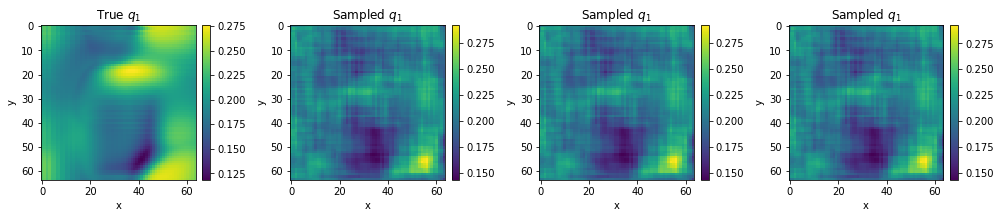

In [10]:
# Check for validation
time = 100

model.load_weights(weights_filepath)
from scipy.ndimage import gaussian_filter
recoded_1 = np.copy(model.predict(swe_train_data[time:time+1,:,:,:]))
recoded_2 = np.copy(model.predict(swe_train_data[time:time+1,:,:,:]))
recoded_3 = np.copy(model.predict(swe_train_data[time:time+1,:,:,:]))

fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(14,12))

cs1 = ax[0].imshow(swe_train_data[time,:,:,0],label='input')
cs2 = ax[1].imshow(recoded_1[0,:,:,0],label='decoded 1')
cs3 = ax[2].imshow(recoded_2[0,:,:,0],label='decoded 2')
cs4 = ax[3].imshow(recoded_3[0,:,:,0],label='decoded 3')

for i in range(4):
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y')
        
fig.colorbar(cs1,ax=ax[0],fraction=0.046, pad=0.04)
fig.colorbar(cs2,ax=ax[1],fraction=0.046, pad=0.04)
fig.colorbar(cs3,ax=ax[2],fraction=0.046, pad=0.04)
fig.colorbar(cs4,ax=ax[3],fraction=0.046, pad=0.04)

ax[0].set_title(r'True $q_1$')
ax[1].set_title(r'Sampled $q_1$')
ax[2].set_title(r'Sampled $q_1$')
ax[3].set_title(r'Sampled $q_1$')

plt.tight_layout()
plt.show()

In [11]:
recoded_1 == recoded_2

array([[[[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],

        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [ True, False, False],
         [False, False, False]],

        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],

        ...,

        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],

        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [Fa